In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("../../data/hour.csv")
sns.set()

df.loc[df['yr']==0,'Year'] = 2011
df.loc[df['yr']==1,'Year'] = 2012
bike_ds_2011 = df[df['Year']==2011]
bike_ds_2012 = df[df['Year']==2012]
bikes_2011 = bike_ds_2011['cnt'].values
bikes_2012 = bike_ds_2012['cnt'].values

bikes_casual_2011 = bike_ds_2011['casual'].values
bikes_casual_2012 = bike_ds_2012['casual'].values

bikes_reg_2011 = bike_ds_2011['registered'].values
bikes_reg_2012 = bike_ds_2012['registered'].values

df['dteday'] = pd.to_datetime(df['dteday'])
df['dteday'] += pd.to_timedelta(df['hr'], unit='h')
df.index = df['dteday']
del df['dteday']


In [2]:
def ecdf(data):
    n = len(data)*1.0
    x = np.sort(data)
    y= np.arange(1,n+1)/n
    return x,y

def verifyECDF():
   # x,y = ecdf(np.log(df['cnt']))

    x_2011,y_2011 = ecdf(bikes_2011)
    
    x_2012,y_2012 = ecdf(bikes_2012)

    _ = plt.plot(x_2011,y_2011,marker='.',linestyle='none')
    _ = plt.plot(x_2012,y_2012,marker='.',linestyle='none')
    _ = plt.margins(0.02)
    _ = plt.xlabel('Demand')
    _ = plt.ylabel('ECDF')
    _ = plt.legend(('2011', '2012'), loc='lower right')
    plt.show()

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y,1)

    return bs_slope_reps, bs_intercept_reps

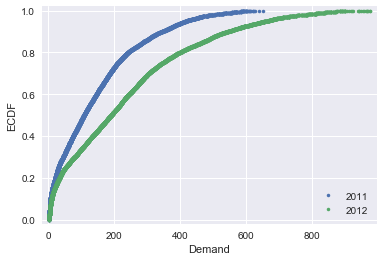

In [3]:
verifyECDF()

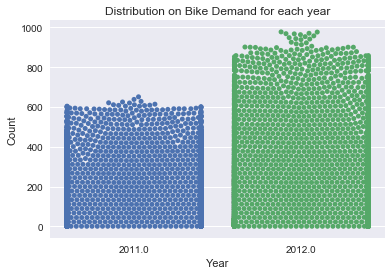

In [4]:
def swarmPlot():
    _ = sns.swarmplot(x='Year',y='cnt',data=df)
    _ = plt.title("Distribution on Bike Demand for each year")
    _ = plt.xlabel("Year")
    _ = plt.ylabel("Count")
    plt.show()
swarmPlot()

In [5]:
    mean_diff = np.mean(bikes_2012) - np.mean(bikes_2011)
    bs_replicates_2011 = draw_bs_reps(bikes_2011,np.mean,10000)
    bs_replicates_2012 = draw_bs_reps(bikes_2012,np.mean,10000)
    bs_diff_replicates = bs_replicates_2012-bs_replicates_2011

    # Compute 95% confidence interval: conf_int
    conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])
    
    # Print the results
    print('difference of means =', mean_diff)
    print('95% confidence interval =', conf_int)

('difference of means =', 90.87191368885655)
('95% confidence interval =', array([85.59656693, 96.13571955]))


In [6]:
def casualVsRegisteredDemand():
    # Make scatter plot of 2011 data
    _ = plt.plot(bikes_reg_2011, bikes_casual_2011, marker='.',
                 linestyle='none', color='blue', alpha=0.5)
    
    # Make scatter plot of 2012 data
    _ = plt.plot(bikes_reg_2012, bikes_casual_2012, marker='.',
                 linestyle='none', color='red', alpha=0.5)
    
    # Label axes and make legend
    _ = plt.xlabel('registered demand')
    _ = plt.ylabel('casual demand')
    _ = plt.legend(('2011', '2012'), loc='upper left')

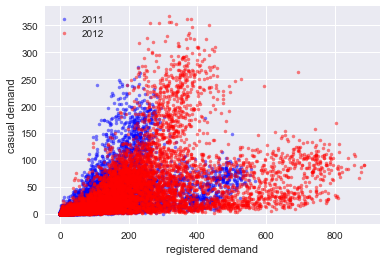

In [7]:
casualVsRegisteredDemand()

In [8]:
def computeLinearRegression():
    slope_2011, intercept_2011 = np.polyfit(bikes_reg_2011, bikes_casual_2011,1)
    slope_2012, intercept_2012 = np.polyfit(bikes_reg_2012, bikes_casual_2012,1)
    
    # Perform pairs bootstrap for the linear regressions
    bs_slope_reps_2011, bs_intercept_reps_2011 = \
            draw_bs_pairs_linreg(bikes_reg_2011, bikes_casual_2011,1000)
    bs_slope_reps_2012, bs_intercept_reps_2012 = \
            draw_bs_pairs_linreg(bikes_reg_2012, bikes_casual_2012,1000)
    
    # Compute confidence intervals of slopes
    slope_conf_int_2011 = np.percentile(bs_slope_reps_2011,[2.5,97.5])
    slope_conf_int_2012 = np.percentile(bs_slope_reps_2012,[2.5,97.5])
    intercept_conf_int_2011 = np.percentile(bs_intercept_reps_2011,[2.5,97.5])
    
    intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012,[2.5,97.5])
    
    
    # Print the results
    print('2011: slope =', slope_2011,
          'conf int =', slope_conf_int_2011)
    print('2011: intercept =', intercept_2011,
          'conf int =', intercept_conf_int_2011)
    print('2012: slope =', slope_2012,
          'conf int =', slope_conf_int_2012)
    print('2012: intercept =', intercept_2012,
          'conf int =', intercept_conf_int_2012)
    
    casualVsRegisteredDemand() 
    # Generate x-values for bootstrap lines: x
    x = np.array([0, 1000])
    
    # Plot the bootstrap lines
    for i in range(100):
        plt.plot(x, bs_slope_reps_2011[i]*x+bs_intercept_reps_2011[i], linewidth=0.5, alpha=0.2, color='blue')
        plt.plot(x, bs_slope_reps_2012[i]*x+bs_intercept_reps_2012[i], linewidth=0.5, alpha=0.2, color='red')

    
    # Draw the plot again
    plt.show()

('2011: slope =', 0.18409491890694893, 'conf int =', array([0.17664594, 0.19195892]))
('2011: intercept =', 7.393972343735807, 'conf int =', array([6.81422914, 7.96976434]))
('2012: slope =', 0.15594611503755795, 'conf int =', array([0.1492005 , 0.16303695]))
('2012: intercept =', 12.740192225527508, 'conf int =', array([11.80037139, 13.62271637]))


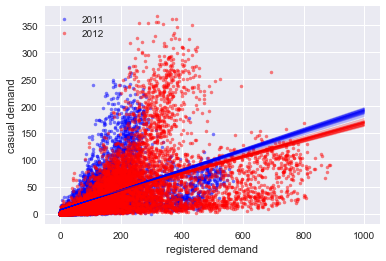

In [10]:
computeLinearRegression()